In [1]:
import xarray as xr
import numpy as np
import scipy as sc
import sklearn as skl
import skimage as ski
from scipy.linalg import norm
from scipy.spatial.distance import euclidean, jensenshannon, correlation
from scipy.stats import wasserstein_distance, ecdf
import skgstat as skg
import pysteps
from pysteps.verification.spatialscores import fss, intensity_scale
from pysteps.verification.salscores import sal
from pysteps.verification.detcontscores import det_cont_fct
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib as mpl

Pysteps configuration file found at: /work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/pysteps/pystepsrc



In [4]:
datapath='/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/MF_ML_PREDICT/season_2020/'
models=['graphcast_','graphcast-oper_','pangu_','pangu-oper_','ifs_']#'fcnv2_dawn','ifs']
labels=['graphcast','graphcast-oper','pangu','pangu-oper','ifs']
references=['USA_era5_convseason_2020.nc','USA_init_convseason_2020.nc']
rlabels=['era5','ifs-init']
figpath='/users/mfeldman/figs/season/'
c1='#648fff' #lightblue
c2='#785ef0' #indigo
c3='#dc267f' #magenta
c4='#fe6100' #orange
c5='#ffb000' #gold
c6='#000000' #black
c7='#808080' #grey
colors=[c1,c2,c4,c3,c6]

graphcast-oper_
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


KeyboardInterrupt: 

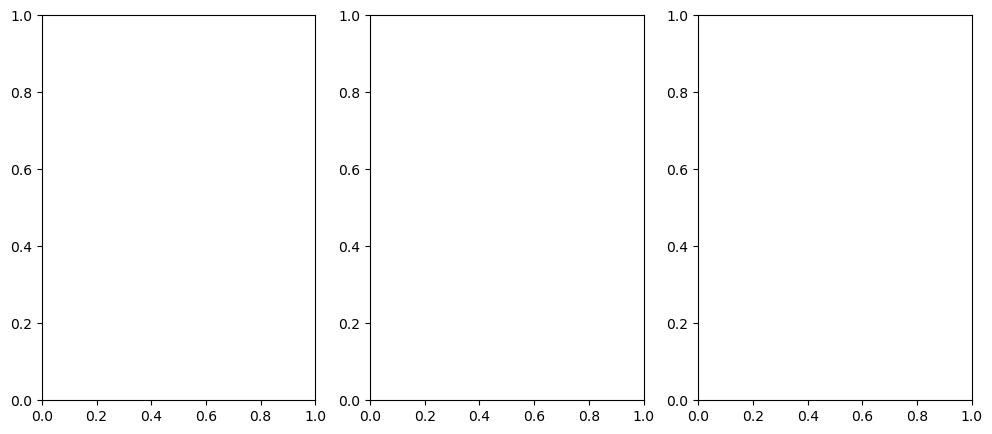

In [39]:
era_ref=xr.open_dataset(datapath+references[0]).sortby('latitude').fillna(0)
cape=era_ref.cape.squeeze().values
wms=(cape * 2)**0.5 * era_ref.bs_06
era_ref=era_ref.assign(wms=lambda era_ref: wms)
vars=['cape','cin','bs_06','bs_03','bs_01','wms']
nn=0
mm=0
for mm in range(len(vars))[:1]:
    var=vars[mm]
    tit=['CAPE [J kg$^{-1}$]','CIN [J kg$^{-1}$]','0-6km shear [m s$^{-1}$]','0-3km shear [m s$^{-1}$]',
         '0-1km shear [m s$^{-1}$]','wmax-shear [m$^2$ s$^{-2}$]'][mm]
    l1=[300,-100,10,5,5,300][mm]
    l2=[1000,-300,20,10,10,500][mm]
    f1=[1,-1,1,1,1,1][mm]
    # fig,axes = plt.subplots(1,3)
    fig2,axes2 = plt.subplots(1,3,figsize=(12, 5))
    for nn in range(1,len(models)):
        kw='latitude'
        kw2='prediction_timedelta'
        model=models[nn]
        label=labels[nn]
        color=colors[nn]
        print(model)
        files=sorted(glob(datapath+'*'+model+'*.nc'))
        sal_s=np.zeros([40,len(files)]); sal_s[:]=np.nan
        sal_a=np.zeros([40,len(files)]); sal_a[:]=np.nan
        sal_l=np.zeros([40,len(files)]); sal_l[:]=np.nan

        for file in range(len(files)-22):
            print(file)
            model_set=xr.open_dataset(files[file]).sortby(kw).fillna(0).squeeze()
            if var=='wms':
                capem=model_set.cape.squeeze().values
                wmsm=(capem * 2)**0.5 * model_set.bs_06
                model_set=model_set.assign(wms=lambda model_set: wmsm )
            for tstep in range(len(model_set[kw2])):
                ref=era_ref.sel(time=(model_set.time+model_set.prediction_timedelta))[var].values[tstep,:,:]
                ref[f1*ref<l1]=0
                mod=model_set[var].values[tstep,:,:]
                mod[f1*mod<l1]=0
                ifile=file-3

                (sal_s[tstep,ifile],sal_a[tstep,ifile],sal_l[tstep,ifile]) = sal(mod,ref)
        ds = xr.Dataset(
            data_vars=dict(
                structure=(["leadtime","date"], sal_s),
                amplitude=(["lead time","date"], sal_a),
                location=(["lead time","date"], sal_l),
            ),
            coords=dict(
                date=(["date"], era_ref.time.values[::2]),
                leadtime=(["leadtime"], model_set.prediction_timedelta.values),
            ),
            attrs=dict(description="SAL score"),
        )
        ds.to_netcdf(datapath+model+var+'_SALscore.nc')
        
        axes2[0].plot(np.arange(40)*6,np.nanmean(sal_s,axis=1),c=color,label=label)
        axes2[0].plot([0,240],np.zeros(2),c='grey')
        #axes2[0].fill_between(np.arange(i+2*len(files))*6,np.nanmax(sal_s,axis=1),np.nanmin(sal_s,axis=1),facecolor=color,alpha=0.3)
        axes2[0].set_title('structure')
        axes2[0].set_xlabel('leadtime [h]')
        axes2[0].set_xticks(np.arange(24,258,24))
        axes2[0].set_ylabel('score [-2,2]')
        #axes2[0].legend()
        axes2[1].plot(np.arange(40)*6,np.nanmean(sal_a,axis=1),c=color,label=label)
        axes2[1].plot([0,240],np.zeros(2),c='grey')
        #axes2[1].fill_between(np.arange(i+2*len(files))*6,np.nanmax(sal_a,axis=1),np.nanmin(sal_a,axis=1),facecolor=color,alpha=0.3)
        axes2[1].set_title('amplitude')
        axes2[1].set_xlabel('leadtime [h]')
        axes2[1].set_xticks(np.arange(24,258,24))
        axes2[1].set_ylabel('score [-2,2]')
        #axes2[1].legend()
        axes2[2].plot(np.arange(40)*6,np.nanmean(sal_l,axis=1),c=color)
        axes2[2].plot([0,240],np.zeros(2),c='grey')
        #axes2[2].fill_between(np.arange(i+2*len(files))*6,np.nanmax(sal_l,axis=1),np.nanmin(sal_l,axis=1),facecolor=color,alpha=0.3)
        axes2[2].set_title('location')
        axes2[2].set_xlabel('leadtime [h]')
        axes2[2].set_xticks(np.arange(24,258,24))
        axes2[2].set_ylabel('score [0,2]')
        fig2.suptitle('SAL score '+str(l1)+' '+tit)


    fig2.tight_layout()
    fig2.show()
    fig2.savefig(figpath+var+'_sal_scores.png')


In [31]:
        ds = xr.Dataset(
            data_vars=dict(
                structure=(["leadtime","date"], sal_s),
                amplitude=(["lead time","date"], sal_a),
                location=(["lead time","date"], sal_l),
            ),
            coords=dict(
                date=(["date"], era_ref.time.values[::2]),
                leadtime=(["leadtime"], model_set.prediction_timedelta.values),
            ),
            attrs=dict(description="SAL score"),
        )

In [38]:
files[22]

'/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/MF_ML_PREDICT/season_2020/USA_conv_graphcast-oper_2020091912.nc'

In [30]:
len(era_ref.time.values[::2])

428